In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import numpy as np
import tensorflow as tf
from keras import backend as K

train_test_dir = "F:\\archive\\TUSimple\\train_set\\seg_label\\list\\train_val_gt.txt"
col_names = ['x', 'y', 'line_1', 'line_2', 'line_3', 'line_4', 'line_5', 'line_6']
df = pd.read_csv(train_test_dir, sep=' ', names=col_names)
df.head()

,x,y,line_1,line_2,line_3,line_4,line_5,line_6
0,/clips/0313-1/6040/20.jpg,/seg_label/0313-1/6040/20.png,0,1,1,1,1,0
1,/clips/0313-1/5320/20.jpg,/seg_label/0313-1/5320/20.png,0,1,1,1,1,0
2,/clips/0313-1/23700/20.jpg,/seg_label/0313-1/23700/20.png,0,1,1,1,1,0
3,/clips/0313-1/51660/20.jpg,/seg_label/0313-1/51660/20.png,0,1,1,1,0,0
4,/clips/0313-1/25680/20.jpg,/seg_label/0313-1/25680/20.png,0,1,1,1,1,0


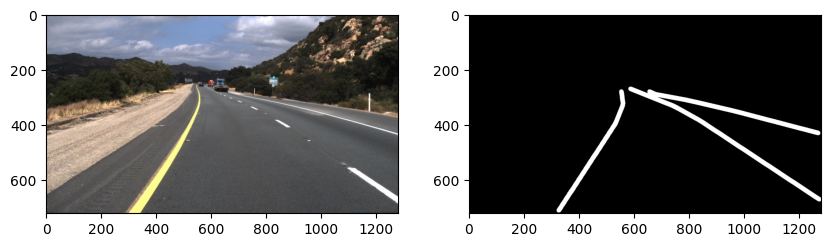

In [2]:
root_path = "F:\\archive\\TUSimple\\train_set\\"

row = df.iloc[3000]

# Download and process images
image = cv2.imread(root_path + row['x'])
mask = cv2.imread(root_path + row['y'])

# Convert lines to white and remove black background
mask_grey = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
_, thresholded = cv2.threshold(mask_grey, 1, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

processed_mask = np.zeros_like(mask)
cv2.drawContours(processed_mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
ax[1].imshow(processed_mask)
plt.show()

In [ ]:
images_path = rf'D:\My Notebooks\TuSimple\train\image'
masks_path = rf'D:\My Notebooks\TuSimple\train\mask'

images = np.array([])
masks = np.array([])

for filename in os.listdir(images_path):
    img = cv2.imread(os.path.join(images_path,filename))
    images.a(img)

for filename in os.listdir(masks_path):
    img = cv2.imread(os.path.join(masks_path,filename))
    masks.append(img)

In [3]:
from glob import glob
from sklearn.model_selection import train_test_split

images = sorted(glob(os.path.join(rf'TuSimple\train\image', "*.png")))
masks = sorted(glob(os.path.join(rf'TuSimple\train\mask', "*.png")))

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.1, random_state=42)

In [4]:
print(f"Train: {len(X_train)} - {len(y_train)}")
print(f"Test: {len(X_test)} - {len(y_test)}")

Train: 3262 - 3262
Test: 363 - 363


In [5]:
H, W = 256, 256

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    x = cv2.resize(x, (W, H))  
    x = x / 255.0   
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [8]:
bath_size = 16

train_dataset = tf_dataset(X_train, y_train, batch=16)
valid_dataset = tf_dataset(X_test, y_test, batch=16)

In [6]:
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [7]:
import numpy as np
import tensorflow as tf
from keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def log_cosh_dice_loss(y_true, y_pred):
    x = dice_loss(y_true, y_pred)
    return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

In [8]:
model = build_unet((H, W, 3))
model.compile(loss=dice_loss, optimizer='adam', metrics=[dice_coef])

In [9]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [11]:
history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=valid_dataset
)

Epoch 1/150
204/204 [==============================] - 272s 1s/step - loss: 0.4653 - dice_coef: 0.5348 - val_loss: 0.7883 - val_dice_coef: 0.2115
Epoch 2/150
204/204 [==============================] - 192s 938ms/step - loss: 0.2706 - dice_coef: 0.7294 - val_loss: 0.3694 - val_dice_coef: 0.6305
Epoch 3/150
204/204 [==============================] - 193s 944ms/step - loss: 0.2466 - dice_coef: 0.7534 - val_loss: 0.2822 - val_dice_coef: 0.7178
Epoch 4/150
204/204 [==============================] - 193s 946ms/step - loss: 0.2354 - dice_coef: 0.7646 - val_loss: 0.2691 - val_dice_coef: 0.7308
Epoch 5/150
204/204 [==============================] - 193s 942ms/step - loss: 0.2254 - dice_coef: 0.7746 - val_loss: 0.2768 - val_dice_coef: 0.7234
Epoch 6/150
204/204 [==============================] - 193s 944ms/step - loss: 0.2214 - dice_coef: 0.7786 - val_loss: 0.2591 - val_dice_coef: 0.7412
Epoch 7/150
204/204 [==============================] - 193s 945ms/step - loss: 0.2150 - dice_coef: 0.7850 - v

In [12]:
model.save('myUNetModel.h5')
model.save_weights('myUNetModelWeights')

In [10]:
model.load_weights('myUNetModelWeights')

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf

def display(display_list):
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

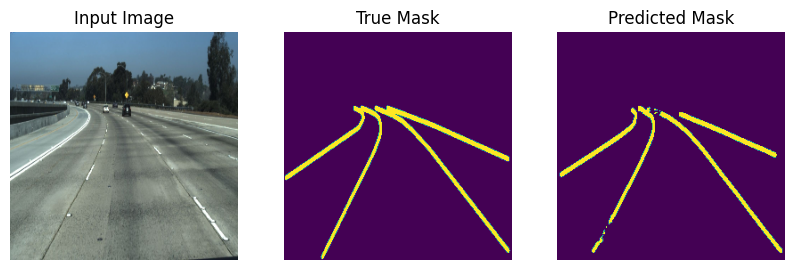

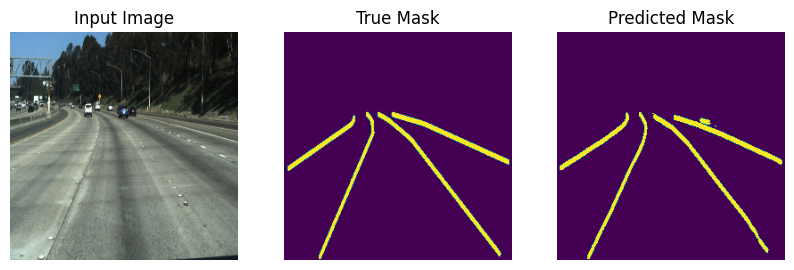

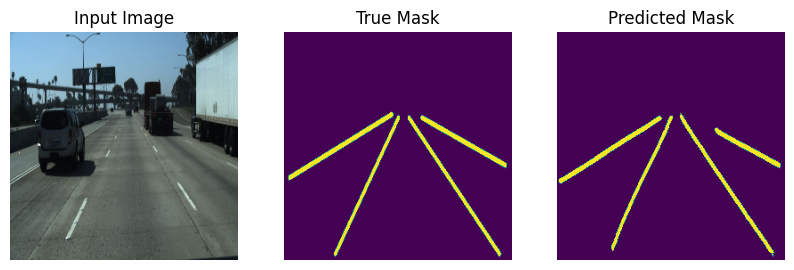

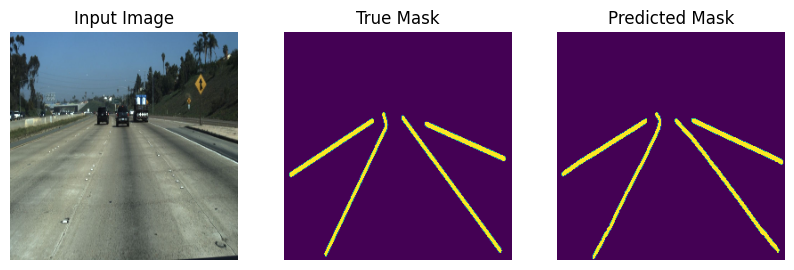

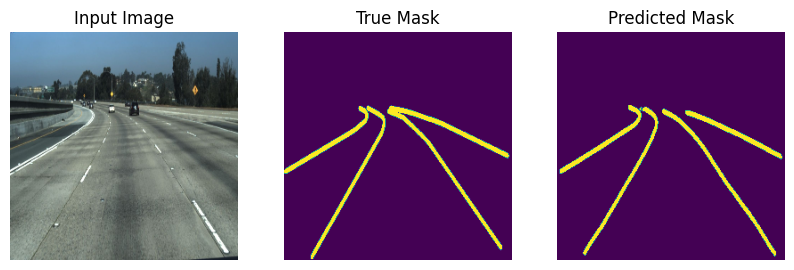

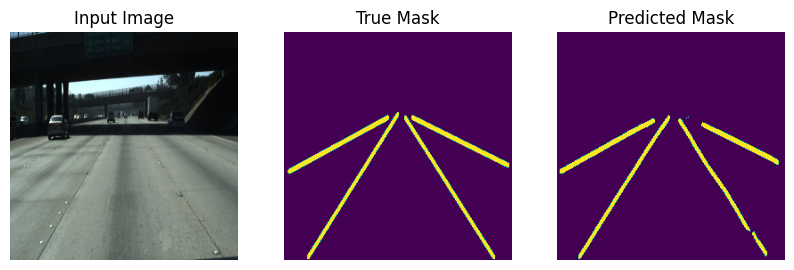

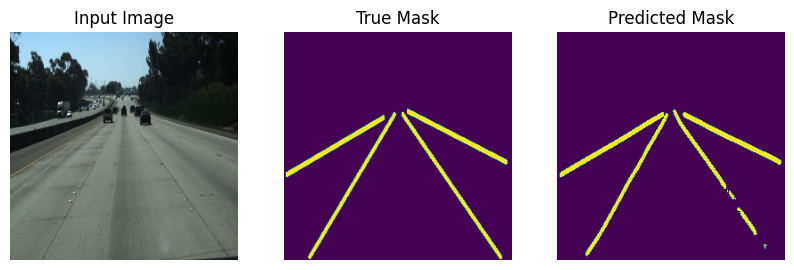

In [14]:
for i, (x, y) in enumerate(zip(X_test, y_test)):
    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (W, H))
    x = image/255.0      
    x = np.expand_dims(x, axis=0)

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)
    
    display([image, mask, y_pred])
    if i == 6:
        break